In [1]:
import os
import sys
sys.path.append("..")
import numpy as np
import torch
from utils.matching import match_reconstruction_ground_truth
import pandas as pd
from utils import Timer, post_process_continuous
from attacks import train_and_attack_fed_avg
from models import FullyConnected
import matplotlib.pyplot as plt
import argparse
import pickle
from attacks import calculate_random_baseline
from datasets.base_dataset import BaseDataset


In [2]:
configs = {
    # Inverting Gradients
    0: {
        'n_global_epochs': 1,
        'lr': 0.01,
        'shuffle': True,
        'attacked_clients': 'all',
        'attack_iterations': 1500,
        'reconstruction_loss': 'cosine_sim',
        'priors': None,
        'epoch_matching_prior': 'mean_squared_error',
        'post_selection': 1,
        'attack_learning_rate': 0.06,
        'return_all': False,
        'pooling': None,
        'perfect_pooling': False,
        'initialization_mode': 'uniform',
        'softmax_trick': False,
        'gumbel_softmax_trick': False,
        'sigmoid_trick': False,
        'temperature_mode': 'constant',
        'sign_trick': True,
        'verbose': False,
        'max_client_dataset_size': 32,
        'post_process_cont': False
    },
    # TabLeak
    52: {
        'n_global_epochs': 1,
        'lr': 0.01,
        'shuffle': True,
        'attacked_clients': 'all',
        'attack_iterations': 1500,
        'reconstruction_loss': 'cosine_sim',
        'priors': None,
        'epoch_matching_prior': 'mean_squared_error',
        'post_selection': 15,
        'attack_learning_rate': 0.06,
        'return_all': False,
        'pooling': 'median',
        'perfect_pooling': False,
        'initialization_mode': 'uniform',
        'softmax_trick': True,
        'gumbel_softmax_trick': False,
        'sigmoid_trick': True,
        'temperature_mode': 'constant',
        'sign_trick': True,
        'verbose': False,
        'max_client_dataset_size': 32,
        'post_process_cont': False
    }
}

In [20]:
client_models=[0,1,2,3]
client_models=[0]


In [21]:


def group_filter(client_gt_projected, client_recon_projected, index, value):
    # print("group_filter applied")
    print("index: ",index, "value: ",value)
    filtered_gt = client_gt_projected[client_gt_projected[:, index] == value]
    filtered_recon = client_recon_projected[client_gt_projected[:, index] == value]
    return filtered_gt, filtered_recon


def subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2):
    # print("subgroup_filter applied")
    print("index1: ", index1,"value1: ", value1, "index2: ",index2,"value2: ", value2)
    condition = (client_gt_projected[:, index1] == value1) & (client_gt_projected[:, index2] == value2)
    filtered_gt = client_gt_projected[condition]
    filtered_recon = client_recon_projected[condition]
    return filtered_gt, filtered_recon


# Normal training

In [22]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/normal/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/normal/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/normal/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}

    # index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]
    
    subgroup_pairs = [
        [(8, "White"), (9, "Male")], # WM
        [(8,"Black"), (9, "Male")], # BM
        [(8, "White"), (9, "Female")], # WW
        [(8, "Black"), (9, "Female")]  # BW
    ]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            # for index, value in index_value_pairs:
            for (index1, value1), (index2, value2) in subgroup_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                # filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)  
                filtered_gt, filtered_recon = subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2)
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  0
(2000, 14) (2000, 14)
index1:  8 value1:  White index2:  9 value2:  Male
(1195, 14) (1195, 14)
index1:  8 value1:  Black index2:  9 value2:  Male
(95, 14) (95, 14)
index1:  8 value1:  White index2:  9 value2:  Female
(526, 14) (526, 14)
index1:  8 value1:  Black index2:  9 value2:  Female
(92, 14) (92, 14)


In [23]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [24]:
all_state_recon

{0: 56.82857142857143}

In [25]:
filename_all_state_inversion = "inversion_normal_adult_all_clients_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


All state reconstructed data has been stored in inversion_normal_adult_all_clients_reconstruction.pickle


In [26]:
local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}

for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "WM":temp_group_score[0],
        "BM":temp_group_score[1] ,
        "WW":temp_group_score[2] ,
        "BW": temp_group_score[3]
    }



all_errors [[0.3888822474596533], [0.5233082706766917], [0.5563552417164583], [0.638975155279503]]


In [27]:
final_group_reco

{0: {'WM': 61.111775254034676,
  'BM': 47.66917293233083,
  'WW': 44.364475828354166,
  'BW': 36.1024844720497}}

In [28]:

filename_all_state_inversion_group = "inversion_normal_adult_subgroup_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

Group reconstructed data has been stored in inversion_normal_adult_subgroup_reconstruction.pickle


# DP training

In [29]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/dp/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/dp/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/dp/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for (index1, value1), (index2, value2) in subgroup_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                # filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)  
                filtered_gt, filtered_recon = subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2)
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  0
(2000, 14) (2000, 14)


KeyboardInterrupt: 

In [ ]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [ ]:
all_state_recon

In [ ]:
filename_all_state_inversion = "inversion_dp_adult_all_clients_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


In [ ]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "WM":temp_group_score[0],
        "BM":temp_group_score[1] ,
        "WW":temp_group_score[2] ,
        "BW": temp_group_score[3]
    }



In [ ]:
final_group_reco

In [ ]:

filename_all_state_inversion_group = "inversion_dp_adult_subgroup_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

# Fair Training

In [ ]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/fair/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/fair/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/fair/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for (index1, value1), (index2, value2) in subgroup_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                # filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)   
                filtered_gt, filtered_recon = subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2)
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

In [ ]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [ ]:
all_state_recon

In [ ]:
filename_all_state_inversion = "inversion_fair_adult_all_clients_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


In [ ]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "WM":temp_group_score[0],
        "BM":temp_group_score[1] ,
        "WW":temp_group_score[2] ,
        "BW": temp_group_score[3]
    }



In [ ]:
final_group_reco

In [ ]:

filename_all_state_inversion_group = "inversion_fair_adult_subgroup_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

# FairDP training

In [ ]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/fairdp/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/fairdp/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/fairdp/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for (index1, value1), (index2, value2) in subgroup_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                # filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)    
                filtered_gt, filtered_recon = subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2)
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

In [ ]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [ ]:
all_state_recon

In [ ]:
filename_all_state_inversion = "inversion_fairDP_adult_all_clients_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


In [ ]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "WM":temp_group_score[0],
        "BM":temp_group_score[1] ,
        "WW":temp_group_score[2] ,
        "BW": temp_group_score[3]
    }

In [ ]:
final_group_reco

In [ ]:

filename_all_state_inversion_group = "inversion_fairDP_adult_subgroup_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

In [ ]:
import os
os.getcwd()

In [ ]:
state_inversion_normal = "inversion_normal_adult_all_clients_reconstruction.pickle"
state_inversion_dp = "inversion_dp_adult_all_clients_reconstruction.pickle"
state_inversion_fair = "inversion_fair_adult_all_clients_reconstruction.pickle"
state_inversion_fairdp = "inversion_fairDP_adult_all_clients_reconstruction.pickle"

inversion_normal_subgroup = "inversion_normal_adult_subgroup_reconstruction.pickle"
inversion_dp_subgroup = "inversion_dp_adult_subgroup_reconstruction.pickle"
inversion_fair_subgroup = "inversion_fair_adult_subgroup_reconstruction.pickle"
inversion_fairdp_subgroup = "inversion_fairDP_adult_subgroup_reconstruction.pickle"

with open(state_inversion_normal, 'rb') as file:
    inversion_normal_state_reconstruction = pickle.load(file)
with open(inversion_normal_subgroup, 'rb') as file:
    inversion_normal_subgroup_reconstruction = pickle.load(file)


with open(state_inversion_dp, 'rb') as file:
    inversion_dp_state_reconstruction = pickle.load(file)    
with open(inversion_dp_subgroup, 'rb') as file:
    inversion_dp_subgroup_reconstruction = pickle.load(file)


with open(state_inversion_fair, 'rb') as file:
    inversion_fair_state_reconstruction = pickle.load(file)    
with open(inversion_fair_subgroup, 'rb') as file:
    inversion_fair_subgroup_reconstruction = pickle.load(file)


with open(state_inversion_fairdp, 'rb') as file:
    inversion_fairdp_state_reconstruction = pickle.load(file)    
with open(inversion_fairdp_subgroup, 'rb') as file:
    inversion_fairdp_subgroup_reconstruction = pickle.load(file)





In [32]:
inversion_normal_all = pd.DataFrame(list(inversion_normal_state_reconstruction.items()), columns=['State', 'Value'])
inversion_dp_all = pd.DataFrame(list(inversion_dp_state_reconstruction.items()), columns=['State', 'Value'])
inversion_fair_all = pd.DataFrame(list(inversion_fair_state_reconstruction.items()), columns=['State', 'Value'])
inversion_fairdp_all = pd.DataFrame(list(inversion_fairdp_state_reconstruction.items()), columns=['State', 'Value'])

inversion_normal_all.head(),inversion_dp_all.head()

(   State      Value
 0      0  44.196429
 1      1  48.660714,
    State      Value
 0      0  42.857143
 1      1  43.303571)

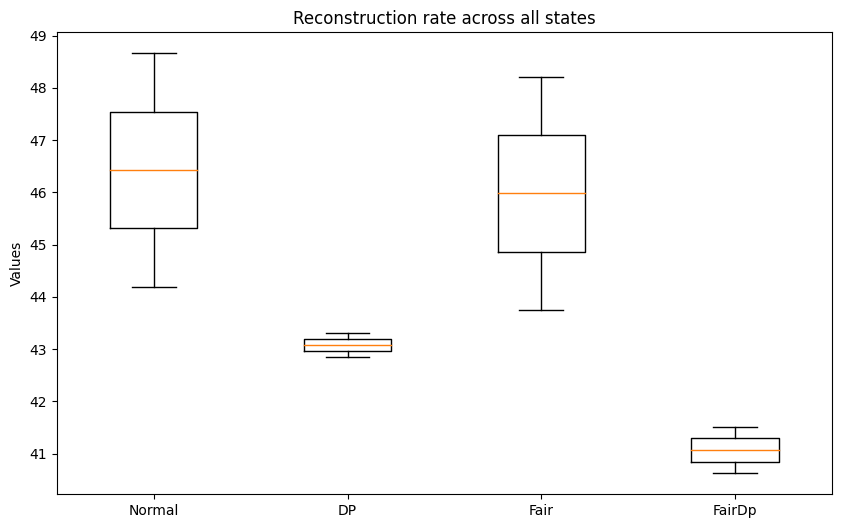

In [33]:

merged_df = pd.DataFrame({
    'inversion_normal_all': inversion_normal_all['Value'],
    'inversion_dp_all': inversion_dp_all['Value'],
    'inversion_fair_all': inversion_fair_all['Value'],
    'inversion_fairdp_all': inversion_fairdp_all['Value']
})

plt.figure(figsize=(10, 6))
plt.boxplot(merged_df.values, labels=['Normal', 'DP',"Fair", "FairDp"])
plt.title('Reconstruction rate across all states')
plt.ylabel('Values')
plt.show()

In [34]:
df_inversion_normal_subgroup_reconstruction = pd.DataFrame(inversion_normal_subgroup_reconstruction).T
df_inversion_normal_subgroup_reconstruction.index.name = 'State'
df_inversion_normal_subgroup_reconstruction.reset_index(inplace=True)

df_inversion_dp_subgroup_reconstruction = pd.DataFrame(inversion_dp_subgroup_reconstruction).T
df_inversion_dp_subgroup_reconstruction.index.name = 'State'
df_inversion_dp_subgroup_reconstruction.reset_index(inplace=True)

df_inversion_fair_subgroup_reconstruction = pd.DataFrame(inversion_fair_subgroup_reconstruction).T
df_inversion_fair_subgroup_reconstruction.index.name = 'State'
df_inversion_fair_subgroup_reconstruction.reset_index(inplace=True)


df_inversion_fairdp_subgroup_reconstruction = pd.DataFrame(inversion_fairdp_subgroup_reconstruction).T
df_inversion_fairdp_subgroup_reconstruction.index.name = 'State'
df_inversion_fairdp_subgroup_reconstruction.reset_index(inplace=True)




In [35]:
df_inversion_normal_subgroup_reconstruction.head()

,State,WM,BM,WW,BW
0,0,46.428571,14.285714,21.428571,25.0
1,1,50.000000,42.857143,17.857143,NaN


In [36]:
df_inversion_normal_subgroup_reconstruction

,State,WM,BM,WW,BW
0,0,46.428571,14.285714,21.428571,25.0
1,1,50.000000,42.857143,17.857143,NaN


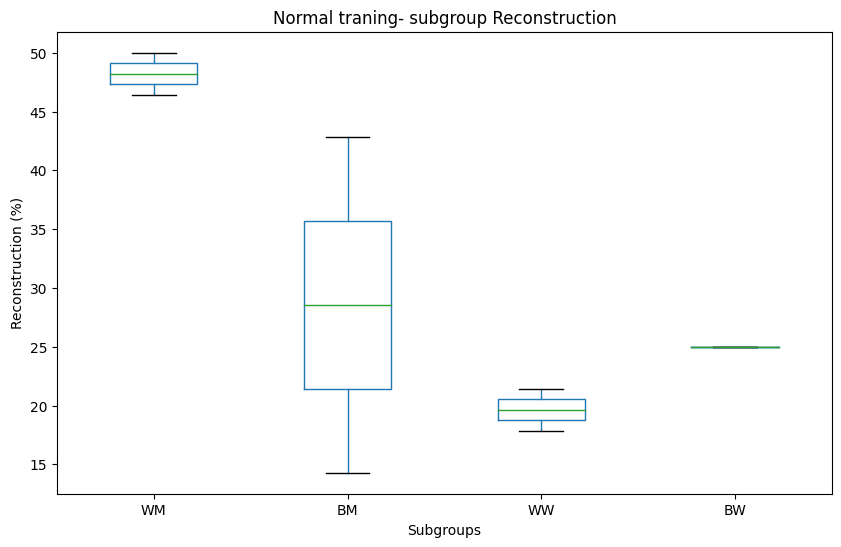

In [37]:
plt.figure(figsize=(10, 6))
df_inversion_normal_subgroup_reconstruction[['WM', 'BM', 'WW', 'BW']].boxplot()
plt.title("Normal traning- subgroup Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Subgroups")
plt.grid(False)
plt.show()

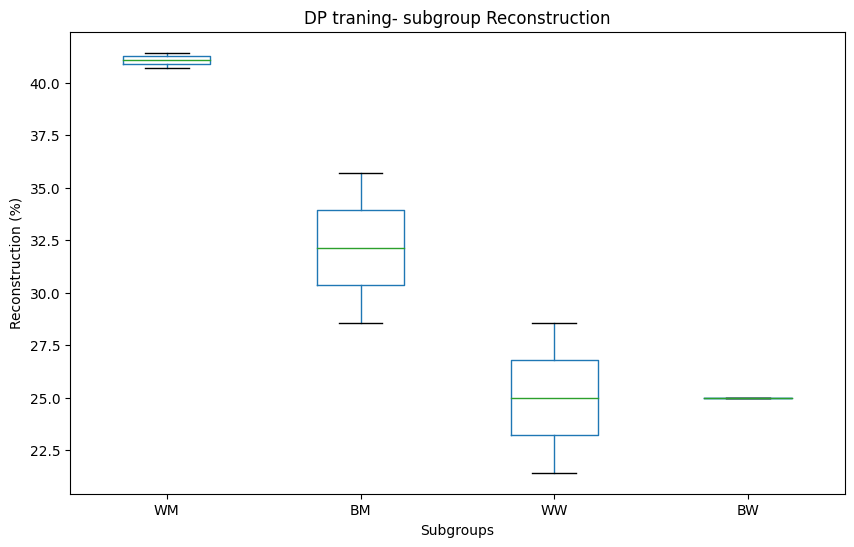

In [38]:

plt.figure(figsize=(10, 6))
df_inversion_dp_subgroup_reconstruction[['WM', 'BM', 'WW', 'BW']].boxplot()
plt.title("DP traning- subgroup Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Subgroups")
plt.grid(False)
plt.show()

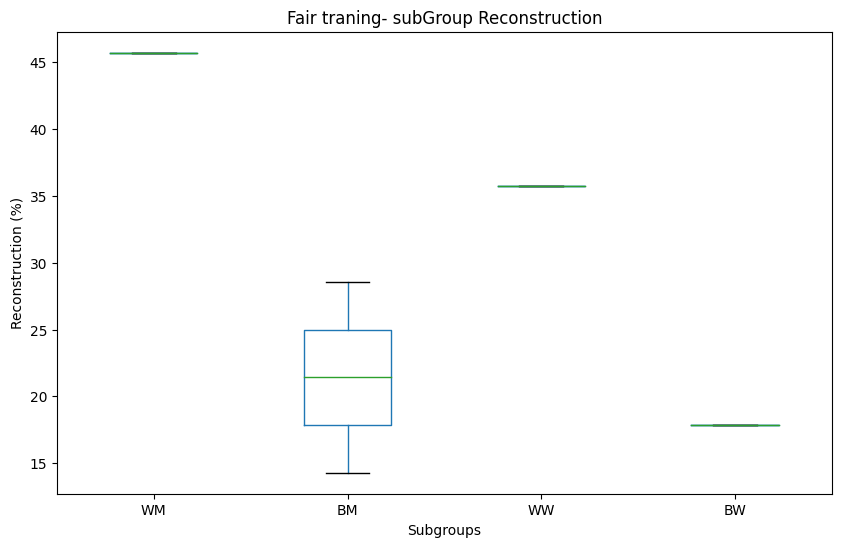

In [39]:

plt.figure(figsize=(10, 6))
df_inversion_fair_subgroup_reconstruction[['WM', 'BM', 'WW', 'BW']].boxplot()
plt.title("Fair traning- subGroup Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Subgroups")
plt.grid(False)
plt.show()

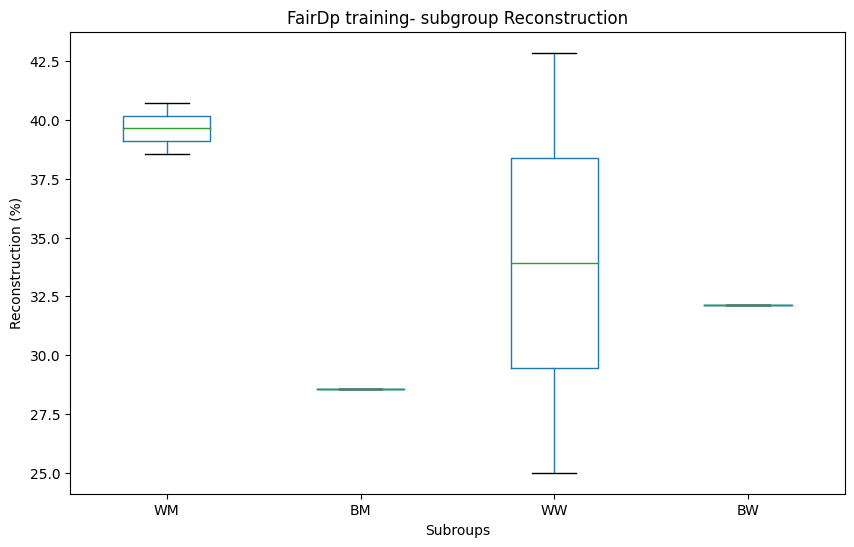

In [40]:

plt.figure(figsize=(10, 6))
df_inversion_fairdp_subgroup_reconstruction[['WM', 'BM', 'WW', 'BW']].boxplot()
plt.title("FairDp training- subgroup Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Subroups")
plt.grid(False)
plt.show()